# Wine dataset
**D3APL – Aplicações em Ciência de dados**
Especialização em Ciência de Dados - IFSP Campinas

Alunos
- Daniel Vargas Shimamoto
- Diego Machado de Assis

# 1. Informações Gerais

## 1.1. Conhecendo  o dataset

Os dados do *Wine dataset* disponível no [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) é uma base clássica de um problema de classificação multi-classe. Os dados são resultados de uma análise química de vinhos cultivados em uma mesma região da Itália, mas provenientes de três culturas diferentes, feita pela [UCI](https://archive.ics.uci.edu/ml/datasets/wine). 

Os dados possuem 178 amostras dividase em 13 *features* relacionadas a três possíveis tipos de vinhos. Este dataset é muito utilizado para problemas de classificação por ter uma estrutura bem comportada, sendo indicado para testes de novos modelos de classificadores

Fonte: https://archive.ics.uci.edu/ml/datasets/wine

## 1.2. Atributos:

### Variável independente
* `Alcohol`
* `Malic acid`
* `Ash`
* `Alcalinity of ash`
* `Magnesium`
* `Total phenols`
* `Flavanoids`
* `Nonflavanoid phenols`
* `Proanthocyanins`
* `Color intensity`
* `Hue`
* `OD280/OD315 of diluted wines`
* `Proline`

### Variáveis dependentes
* `class_0`
* `class_1`
* `class_2`

## 1.3. Objetivo
Criar um Regressor Logístico com *regularização L2* para um problema de classificação multi-classe implementando as seguintes funcionalidades 
* Diferentes versões do gradiente descendente (otimizador)
 * Hiperparâmetro ***optimizer*** com uma validação
   * optimizer = 'batch', default: Batch gradiente descent
   * optimizer = 'mini': Mini-batch gradiente descent
   * optimizer = 'stochastic': Stochastic gradiente descent
* Uma estratégia de classificação multi-classe
 * One vs Rest
* Validar modelo com [*LogisticRegression*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) e [*SGDClassifier*](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) nas versões *default* e após *fine-tuning*

# 1. Importações

In [1]:
# Bibliotecas Básicas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

# Auxiliares
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = load_wine(as_frame=True)
df = df.frame
df.head(3)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0


# 2. Limpeza e pré-processamento
## 2.1 Limpeza dos dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [4]:
# Dados nulos
print(f'O dataset possui {df.isnull().sum().sum()} dados nulos')

# Dados duplicados
print(f'O dataset possui {df.duplicated().sum()} dados duplicados')

O dataset possui 0 dados nulos
O dataset possui 0 dados duplicados


### 2.2. Separação da base de teste

Após a verificação dos dados duplicados e dos valores vazios, vamos começar a análise exploratória. Antes de começar a analisar os dados, vamos dividir a base em dados de treino e teste. Para montar um modelo que seja consistente os dados de testes não devem ser usados para analisar e preparar a base, de modo que a divisão deve ser feita anteriormente.
O parâmetro **target** define a que classe cada amostra pertence. Dessa forma vamos estratificar a amostra nesse parâmetro, garantindo a homogeneidade em relação a esse atributo.

In [5]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['target'], random_state=42)

print(f'Temos {df_train.shape} dados de treino e {df_test.shape} dados de teste')

Temos (142, 14) dados de treino e (36, 14) dados de teste


In [6]:
print(f"Dados de Treino\n{df_train['target'].value_counts()/len(df_train['target'])}\n")
print(f"Dados de Teste\n{df_test['target'].value_counts()/len(df_test['target'])}\n")

Dados de Treino
1    0.401408
0    0.330986
2    0.267606
Name: target, dtype: float64

Dados de Teste
1    0.388889
0    0.333333
2    0.277778
Name: target, dtype: float64



### 2.3. Análise exploratória

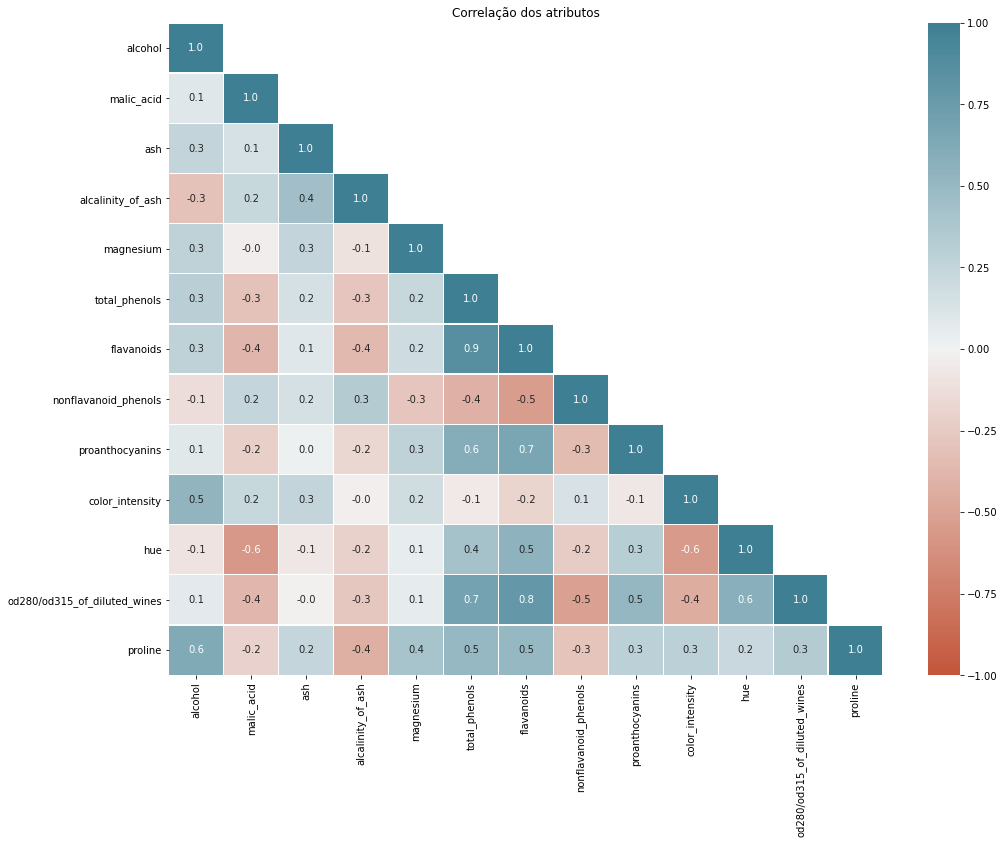

In [7]:
# Correlação das Features
mask = np.zeros_like(df_train.iloc[:,:-1].corr())
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(16,12))
sns.heatmap(df_train.iloc[:,:-1].corr(), linewidths=.3, cmap=sns.diverging_palette(20, 220, as_cmap=True), vmin=-1, vmax=1, annot = True, fmt = '.1f', mask = mask)
plt.title('Correlação dos atributos')
plt.show()

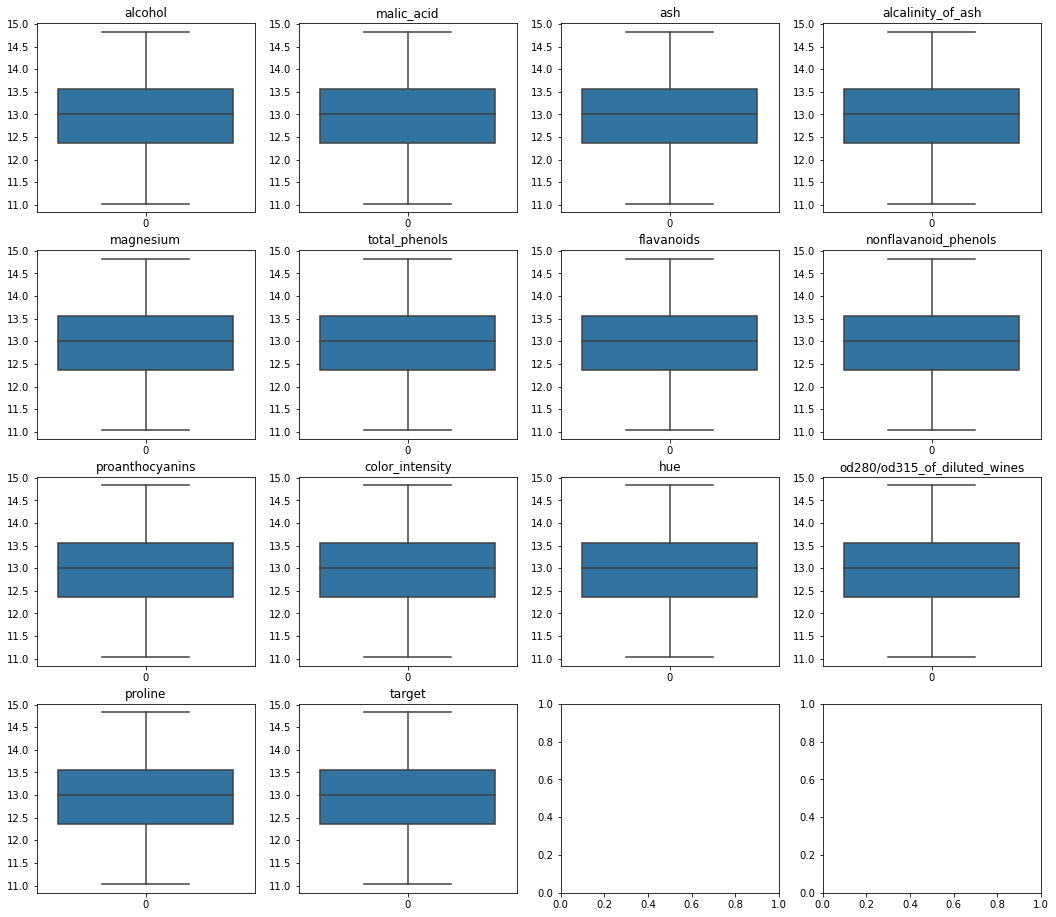

In [8]:
fig, axs = plt.subplots(4,4, figsize=(18,16))

cont = 0
for i in range(0, 4):
    for j in range(0, 4):
        sns.boxplot(data=df_train.iloc[:,0], ax = axs[i][j])
        axs[i][j].set_title(df_train.columns[cont])
        cont+=1
        if cont > 13:
            break

Embora existam algumas correlações altas, vamos manter todas as features para treinamento dos modelos.

Os boxplots não mostra nenhum outliers nos dados

### 2.4 Preparação dos dados para o treinamento dos modelos

Para realizar o treinamento dos modelos iremos utilizar a classe **GridSearchCV** do pacote [*sklearn.model_selection*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Será realizada validação cruzada para avaliação do modelo, utilizando o **Kfold** com 5 grupos.

A estrutura geral de execução de todos os modelos será a mesma. Inicialmente treinaremos o modelo com os parâmetros *default* e computaremos o erro com os dados de validação.Em seguida será criado um dicionário de parâmetros a serem testados pela função de *grid search*, computando o erro para a versão *fine-tuning*

In [9]:
# Separando as variáveis dependente das independentes
df_train_features = df_train.drop(columns = ['target'])
df_train_target = df_train['target'].values

# 3. Modelo Regressor Logístico

# 4. Utilização dos Modelos

## 4.1 Regressor Logístico - Batch gradient descent

## 4.4.1 Versão Default

## 4.4.2 Fine-Tuning

## 4.2 Regressor Logístico - Mini-batch gradient descent

## 4.4.1 Versão Default

## 4.4.2 Fine-Tuning

## 4.3 Regressor Logístico - Stochastic gradient descent

## 4.4.1 Versão Default

## 4.4.2 Fine-Tuning

# 4.4 LogisticRegression

In [10]:
def Log_reg_model (df_train_features,df_train_target,LR_grid_params,num_folds = 5):
    LR_model = GridSearchCV(
        estimator=LogisticRegression(random_state=42),
        param_grid=LR_grid_params,
        cv=num_folds,
        scoring="accuracy"
    )

    LR_model.fit(df_train_features, df_train_target)

    print(f'Melhores parametros: {LR_model.best_params_}')
    print(f'Acurácia: {LR_model.best_score_}')
    return LR_model

## 4.4.1 Versão Default

In [11]:
# Parâmetros Default
LR_grid_params_default = {
    'penalty':['l2'],
    'C':[1.0],  
    'solver':['lbfgs'],
    'max_iter':[100]}

LR_default = Log_reg_model(df_train_features,df_train_target,LR_grid_params_default)

Melhores parametros: {'C': 1.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Acurácia: 0.9440886699507389


## 4.4.2 Fine-Tuning

In [12]:
# Parâmetros fine-tuning
LR_grid_params_ft = {
    'penalty':['l2', 'none'],
    'C': np.logspace(-2, 2, 5),   
    'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
    'max_iter':[100,1000,10000]}

LR_ft = Log_reg_model(df_train_features,df_train_target,LR_grid_params_ft)

Melhores parametros: {'C': 10.0, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Acurácia: 0.9724137931034482


# 4.4 SGDClassifier

In [13]:
def SGDClassifier_model (df_train_features,df_train_target,SGD_grid_params,num_folds = 5):
    SGD_model = GridSearchCV(
        estimator=SGDClassifier(random_state=42),
        param_grid=SGD_grid_params,
        cv=num_folds,
        scoring="accuracy"
    )

    SGD_model.fit(df_train_features, df_train_target)

    print(f'Melhores parametros: {SGD_model.best_params_}')
    print(f'Acurácia: {SGD_model.best_score_}')
    return SGD_model

## 4.4.1 Versão Default

In [14]:
# Parâmetros Default
SGD_grid_params_default = {
    'penalty':['l2'],
    'alpha': [0.0001],  
    'loss':['hinge'],  
    'max_iter':[1000],
    'learning_rate':['optimal']
}

SGD_default = SGDClassifier_model(df_train_features,df_train_target,SGD_grid_params_default)

Melhores parametros: {'alpha': 0.0001, 'learning_rate': 'optimal', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2'}
Acurácia: 0.44802955665024635


## 4.4.2 Fine-Tuning

In [15]:
# Parâmetros FT
SGD_grid_params_default = {
    'penalty':['l2','l1'],
    'alpha': np.logspace(-6, -2, 5),
    'loss':['hinge','log','squared_error'],  
    'max_iter':[100,1000,10000],
    'learning_rate':['constant','optimal','adaptive','invscaling']
}

SGD_ft = SGDClassifier_model(df_train_features,df_train_target,SGD_grid_params_default)

Melhores parametros: {'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 100, 'penalty': 'l2'}
Acurácia: 0.6406403940886699


# 5 Conclusão e próximos passos